# Structured Sparsity

## Description

In a target application, we want to sense the components of a signal $\mathbf{x}$, that we indicate as $x_i$, with $ i = 0,\dots, N -1 $. We know that $\mathbf{x}$ is a sparse signal, such that if the  $x_i \, \text{with} \, i < \lfloor \frac{N}{2}\rfloor $ is non-zero, then $x_{i + \lfloor \frac{N}{2}\rfloor }$ is also non-zero. This is to say that the support of the first half and second half of  $\mathbf{x}$ follows the same structure. The goal of this project is to develop and evaluate techniques to recover such sparse signals.

We use $\mathbf{x}$ to denote an Nx1 real-valued sparse vector. The vector of $M$ measurements in our setup is given by $\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{v}$ where $\mathbf{A}$ is an $M \times N$ random CS matrix and $\mathbf{v}$ is a a Nx1 vector of white Gaussian noise samples. The entries of $\mathbf{A}$ are drawn from the standard Gaussian Distribution $\mathcal{N}(0,1)$, and then the colums are normalized to have unit $\ell2$ norm. The vector $\mathbf{v}$ is additive white Gaussian noise. In this project, we use $N = 64$. 

In [1]:
%load_ext autoreload
%autoreload 2

# change to False if you don't want to render figures with LaTex
USE_LATEX = True

# save results
SAVE_RESULTS = False

# save figures
SAVE_FIGURES = True
FIGSIZE = (6.4, 4.8)

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact, IntSlider, Layout
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
import time
from utils.check_structure import check_structure
from utils.reorder_columns import reorder_columns
from utils.stack_odd_even import stack_odd_even

import sys
if sys.version_info[1] >= 11:
    from shutil import which as check_for_installation
else:
    from distutils.spawn import find_executable as check_for_installation

if USE_LATEX and check_for_installation('latex'):
    print('TeX installation found')
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Times",
    })
else:
    print('TeX installation not found')
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    })
plt.rcParams["figure.figsize"] = FIGSIZE

# xdata = np.load('data/Project_Structured_Sparsity.npy')
# xdata.shape

TeX installation found


## Methodology and Evaluation

Conduct a brief literature study to orient yourself on this problem. Implement convex optimization-based algorithms to recover the structured sparse signal. Compare your developed method with a general CS-recovery algorithm (such as ISTA) that does not exploit the structured sparsity.

The methods must be evaluated on the “Project_Structured_Sparsity.npy” dataset using performance metrics such as reconstruction error and computational time. These metrics must be studied as a function of the number of measurements, i.e., $M$. 

Generating sparse vectors with the given structure:

In [2]:
from utils.generate_structured_data import generate_structured_data

M = 50              # Number of Measurements
N = 64              # Number of original variables
NS = 200           # Number of samples
K = 4               # Number of non-zero entries within the first half of the vector
d = 2               # Number of blocks
noise_var = 0.005     # Noise variance

Y, A, X = generate_structured_data(num_measurements=M, num_variables=N, num_samples=NS, sparsity_half=K, noise_var=noise_var)
A_reordered = reorder_columns(A)

In [3]:
print(f"Dimensions:\nY = {Y.shape}\nA = {A.shape}\nX = {X.shape}")

Dimensions:
Y = (50, 200)
A = (50, 64)
X = (64, 200)


Saving results:

In [4]:
if SAVE_RESULTS:
    from scipy.io import savemat
    out_mat = dict()
    out_mat['X'] = X

    np.save("data/Project_Structured_Sparsity", X)
    savemat("data/Project_Structured_Sparsity.mat", out_mat)

Visualizing our data:

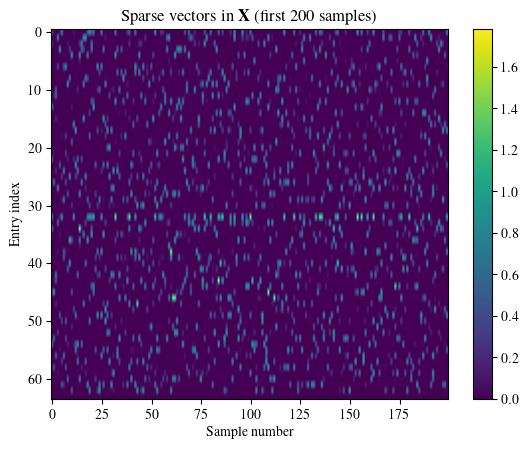

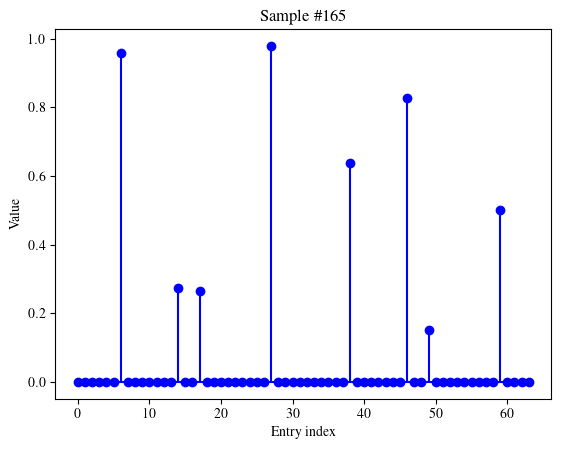

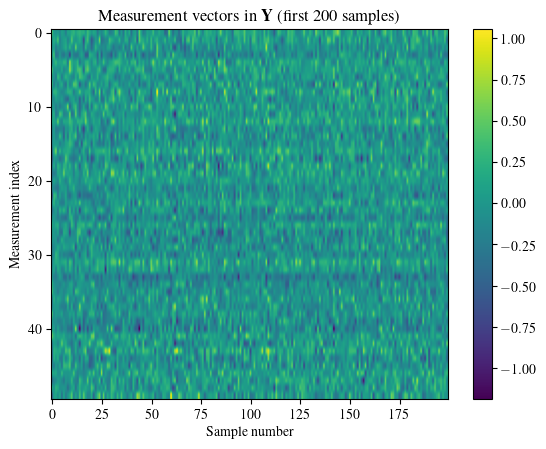

SNR = 20.83 dB


In [31]:
# Plot the first 200 sparse vectors in X
fig = plt.figure()
plt.imshow(X[:,:], aspect='auto')
plt.title(r'Sparse vectors in $\mathbf{X}$ (first 200 samples)')
plt.ylabel(r'Entry index')
plt.xlabel(r'Sample number')
plt.colorbar()
if SAVE_FIGURES:
    # plt.savefig("figures/first_200_vectors.pdf", bbox_inches='tight')
    plt.savefig("figures/first_200_vectors.png", bbox_inches='tight')

# Plot a single sample from X
fig = plt.figure()
sample_nr = 165
plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b')
plt.title(rf'Sample \#{sample_nr}')
plt.xlabel(r'Entry index')
plt.ylabel(r'Value')
if SAVE_FIGURES:
    # plt.savefig("figures/single_sample.pdf", bbox_inches='tight')
    plt.savefig("figures/single_sample.png", bbox_inches='tight')
plt.show()

# Plot the first 200 measurement vectors in Y
fig = plt.figure()
plt.imshow(Y[:,:], aspect='auto')
plt.title(r'Measurement vectors in $\mathbf{Y}$ (first 200 samples)')
plt.ylabel(r'Measurement index')
plt.xlabel(r'Sample number')
plt.colorbar()
if SAVE_FIGURES:
    # plt.savefig("figures/first_200_measurements.pdf", bbox_inches='tight')
    plt.savefig("figures/first_200_measurements.png", bbox_inches='tight')
plt.show()

# Signal-to-noise ratio
noise_power = noise_var #np.mean(np.square(V))
signal_power = np.mean(np.square(A @ X))
snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
print(f"SNR = {snr_db:.2f} dB")

## CS Reconstruction without exploiting support structure

Lasso regression and OMP to reconstruct *X* from *Y* and *A*:

In [6]:
# LASSO

def reconstruct_lasso(Y, A, X, alpha=0.0075, silent=False):
    start_time = time.time()
    
    lasso = Lasso(alpha=alpha).fit(A, Y)
    X_rec_lasso = lasso.coef_.T
    
    end_time = time.time()
    lasso_execution_time = end_time - start_time

    mse_lasso = mean_squared_error(X_rec_lasso, X, multioutput='raw_values')    

    if not silent:
        print(f"Signal reconstruction execution time with LASSO: {lasso_execution_time:.3f} seconds")
        print(f'Average MSE with LASSO = {np.mean(mse_lasso):.4f}')

    return X_rec_lasso, mse_lasso, lasso_execution_time

def reconstruct_omp(Y, A, X, K=K, silent=False):
    start_time = time.time()

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=2*K).fit(A, Y)
    X_rec_omp = omp.coef_.T
    
    end_time = time.time()
    omp_execution_time = end_time - start_time

    mse_omp = mean_squared_error(X_rec_omp, X, multioutput='raw_values')

    if not silent:
        print(f"Signal reconstruction execution time with OMP: {omp_execution_time:.3f} seconds")
        print(f'Average MSE with OMP = {np.mean(mse_omp):.4f}')

    return X_rec_omp, mse_omp, omp_execution_time

X_rec_lasso, mse_lasso, lasso_execution_time = reconstruct_lasso(Y, A, X)
X_rec_omp, mse_omp, omp_execution_time = reconstruct_omp(Y, A, X)


# alphas = 0.001 * np.arange(1000)
# mses = np.zeros_like(alphas)
# for i, alpha in enumerate(alphas):
#     lasso_i = Lasso(alpha=alpha).fit(A, Y)
#     X_rec_lasso_i = lasso_i.coef_.T
#     MSE_lasso_i = mean_squared_error(X_rec_lasso_i, X, multioutput='raw_values')
#     mses[i] = np.sum(MSE_lasso_i)

# plt.figure()
# plt.plot(mses)
# plt.show

Signal reconstruction execution time with LASSO: 0.019 seconds
Average MSE with LASSO = 0.0173
Signal reconstruction execution time with OMP: 0.029 seconds
Average MSE with OMP = 0.0024


Results for a given sample:

## CS Reconstruction using knowledge of the support structure - Approach 1: primitive method

Reconstruction for the entire dataset (takes long):

In [7]:
from utils.recover_structured_sparse_signal_with_regularization import recover_structured_sparse_signal_with_regularization

# warning: code will run for approximately 15-20 minutes if set to True
reconstruct_entire_dataset = True

def reconstruct_primitive_dataset(Y, A, X, alpha=0.1, silent=False):
    start_time = time.time()

    X_rec_structured_primitive = np.apply_along_axis(lambda y: recover_structured_sparse_signal_with_regularization(CS_mat=A, y=y, alpha=alpha), axis=1, arr=Y.T).T
    
    end_time = time.time()
    structured_execution_time_primitive = end_time - start_time

    mse_structured_primitive = mean_squared_error(X_rec_structured_primitive, X, multioutput='raw_values')
    
    if not silent:
        print(f"Structured signal reconstruction execution time with primitive method: {structured_execution_time_primitive:.3f} seconds")
        print(f'Average MSE primitive method = {np.mean(mse_structured_primitive):.4f}')

    return X_rec_structured_primitive, mse_structured_primitive, structured_execution_time_primitive

if reconstruct_entire_dataset:
    X_rec_structured_primitive, mse_structured_primitive, _ = reconstruct_primitive_dataset(Y, A, X)

Structured signal reconstruction execution time with primitive method: 25.787 seconds
Average MSE primitive method = 0.0038


Reconstruction for a single sample:

In [8]:
def reconstruct_primitive_sample(sample_nr, alpha=0.1):
    if 'X_rec_structured_primitive' in locals() and 'mse_structured_primitive' in locals():
        X_rec_structured_primitive_sample = X_rec_structured_primitive[:,sample_nr]
        mse_structured_primitive_sample = mse_structured_primitive[sample_nr]
    else:
        X_rec_structured_primitive_sample = recover_structured_sparse_signal_with_regularization(CS_mat=A, y=Y[:,sample_nr], alpha=alpha)
        mse_structured_primitive_sample = mean_squared_error(X_rec_structured_primitive_sample, X[:,sample_nr])
    
    return X_rec_structured_primitive_sample, mse_structured_primitive_sample

## CS Reconstruction using knowledge of the support structure - Approach 2: block OMP

Reconstruction for the entire dataset:

In [9]:
from utils.block_omp import block_omp

reconstruct_entire_dataset = True

def reconstruct_bomp_dataset(Y, A_reordered, X, d=2, K=4, silent=False):
    start_time = time.time()

    X_rec_structured_bomp = np.apply_along_axis(lambda y: block_omp(A=A_reordered, y=y, block_size=d, sparsity_level=2*K, tolerance=1e-6), axis=1, arr=Y.T).T
    X_rec_structured_bomp = np.apply_along_axis(stack_odd_even, axis=0, arr=X_rec_structured_bomp)
    
    end_time = time.time()
    structured_execution_time_bomp = end_time - start_time

    mse_structured_bomp = mean_squared_error(X_rec_structured_bomp, X, multioutput='raw_values')
    
    if not silent:
        print(f"Structured signal reconstruction execution time with B-OMP: {structured_execution_time_bomp:.3f} seconds")
        print(f'Average MSE B-OMP = {np.mean(mse_structured_bomp):.4f}')

    return X_rec_structured_bomp, mse_structured_bomp, structured_execution_time_bomp

if reconstruct_entire_dataset:
    X_rec_structured_bomp, mse_structured_bomp, _ = reconstruct_bomp_dataset(Y, A_reordered, X)

Structured signal reconstruction execution time with B-OMP: 0.060 seconds
Average MSE B-OMP = 0.0512


Reconstruction for a single sample:

In [10]:
def reconstruct_bomp_sample(sample_nr):
    if 'X_rec_structured_bomp' in locals() and 'mse_structured_bomp' in locals():
        X_rec_structured_bomp_sample = X_rec_structured_bomp[:,sample_nr]
        mse_structured_bomp_sample = mse_structured_bomp[sample_nr]
    else:
        X_rec_structured_bomp_sample = block_omp(A_reordered, Y[:,sample_nr], block_size=2, sparsity_level=2*K, tolerance=1e-6)
        X_rec_structured_bomp_sample = stack_odd_even(X_rec_structured_bomp_sample)
        mse_structured_bomp_sample = mean_squared_error(X_rec_structured_bomp_sample, X[:,sample_nr])

    return X_rec_structured_bomp_sample, mse_structured_bomp_sample

## CS Reconstruction using knowledge of the support structure - Approach 3: mixed $\ell_2 / \ell_1$ algorithm

Reconstruction for the entire dataset (takes long)

In [11]:
from utils.l2l1_algorithm import l2l1_algorithm

# warning: code will run for approximately 8-10 minutes if set to True
reconstruct_entire_dataset = True

def reconstruct_l2l1_dataset(Y, A_reordered, X, N=64, d=2, noise_var=0.0, silent=False):
    start_time = time.time()

    X_rec_structured_l2l1 = np.apply_along_axis(lambda y: l2l1_algorithm(A=A_reordered, y=y, N=N, d=d, sigma=np.sqrt(noise_var)), axis=0, arr=Y)
    X_rec_structured_l2l1 = np.apply_along_axis(stack_odd_even, axis=0, arr=X_rec_structured_l2l1)
    
    end_time = time.time()
    structured_execution_time_l2l1 = end_time - start_time

    mse_structured_l2l1 = mean_squared_error(X_rec_structured_l2l1, X, multioutput='raw_values')
    
    if not silent:
        print(f"Structured signal reconstruction execution time with l2/l1: {structured_execution_time_l2l1:.3f} seconds")
        print(f'Average MSE l2/l1 = {np.mean(mse_structured_l2l1):.4f}')

    return X_rec_structured_l2l1, mse_structured_l2l1, structured_execution_time_l2l1

if reconstruct_entire_dataset:
    X_rec_structured_l2l1, mse_structured_l2l1, _ = reconstruct_l2l1_dataset(Y, A_reordered, X, noise_var=noise_var)

Structured signal reconstruction execution time with l2/l1: 6.814 seconds
Average MSE l2/l1 = 0.0476


Reconstruction for a single sample:

In [12]:
def reconstruct_l2l1_sample(sample_nr):
    if 'X_rec_structured_l2l1' in locals() and 'mse_structured_l2l1' in locals():
        X_rec_structured_l2l1_sample = X_rec_structured_l2l1[:,sample_nr]
        mse_structured_l2l1_sample = mse_structured_l2l1[sample_nr]
    else:
        X_rec_structured_l2l1_sample = l2l1_algorithm(A=A_reordered, y=Y[:, sample_nr], N=N, d=d, sigma=np.sqrt(noise_var))
        X_rec_structured_l2l1_sample = stack_odd_even(X_rec_structured_l2l1_sample)
        mse_structured_l2l1_sample = mean_squared_error(X_rec_structured_l2l1_sample, X[:,sample_nr])

    return X_rec_structured_l2l1_sample, mse_structured_l2l1_sample

Reconstruction rate: a reconstruction is successful if the mean absolute error's relative error is less than 30%

In [13]:
def reconstruction_rate(X, X_rec, tol=0.3):
    succesful_reconstructions = (np.mean(np.abs(X-X_rec), axis=0) < tol * np.mean(np.abs(X), axis=0)).sum()
    # print(succesful_reconstructions)
    return succesful_reconstructions / X.shape[1]

## Interactive visualisations

In [77]:
# rerun functions for interactive plot

# M = 32              # Number of Measurements
# NS = 200           # Number of samples
# noise_var = 0.05     # Noise variance
# Y, A, X = generate_structured_data(num_measurements=M, num_variables=N, num_samples=NS, sparsity_half=K, noise_var=noise_var)
# A_reordered = reorder_columns(A)
# noise_power = noise_var #np.mean(np.square(V))
# signal_power = np.mean(np.square(A @ X))
# snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
# print(f"SNR = {snr_db:.2f} dB")

X_rec_lasso, mse_lasso, _ = reconstruct_lasso(Y, A, X)
X_rec_omp, mse_omp, _ = reconstruct_omp(Y, A, X)
X_rec_structured_primitive, mse_structured_primitive, _ = reconstruct_primitive_dataset(Y, A, X)
X_rec_structured_bomp, mse_structured_bomp, _ = reconstruct_bomp_dataset(Y, A_reordered, X)
X_rec_structured_l2l1, mse_structured_l2l1, _ = reconstruct_l2l1_dataset(Y, A_reordered, X, noise_var=noise_var)

SNR = 2.82 dB
Signal reconstruction execution time with LASSO: 0.010 seconds
Average MSE with LASSO = 0.0260
Signal reconstruction execution time with OMP: 0.024 seconds
Average MSE with OMP = 0.0582
Structured signal reconstruction execution time with primitive method: 26.157 seconds
Average MSE primitive method = 0.0329
Structured signal reconstruction execution time with B-OMP: 0.097 seconds
Average MSE B-OMP = 0.1043
Structured signal reconstruction execution time with l2/l1: 7.863 seconds
Average MSE l2/l1 = 0.0357


In [65]:
sample_nr_to_save = 20

def interactive_plot_no_structure_fn(sample_nr):
    mse_str_lasso = rf"MSE of LASSO for sample \#{sample_nr} = {mse_lasso[sample_nr]:.4f}"
    mse_str_omp = r"MSE of OMP \hspace{7.5pt} for sample \#" + f"{sample_nr} = {mse_omp[sample_nr]:.4f}"

    # print(check_structure(X[:,sample_nr]))
    # print(check_structure(X_rec_lasso[:,sample_nr]))
    # print(check_structure(X_rec_omp[:,sample_nr]))
    # print('\n')
    
    plt.figure()
    plt.title(r"Reconstruction without knowledge of the structure for the sample \#" + f"{sample_nr}" + '\n' +rf"($M={M}$, SNR = " + (f"{snr_db:.2f}" if snr_db != np.inf else r"$\infty$") + rf" dB, $\sigma^2 = {noise_var}$)")
    plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b', label=r"$\mathbf{X}$")
    markerline_lasso, stemlines_lasso, baseline_lasso = plt.stem(X_rec_lasso[:,sample_nr], linefmt='r', markerfmt='+', basefmt=' ', label=r"$\mathbf{X}_\mathrm{rec}^\mathrm{LASSO}$")
    markerline_omp, stemlines_omp, baseline_omp = plt.stem(X_rec_omp[:,sample_nr], linefmt='#00ff00', markerfmt='x', basefmt=' ', label=r"$\mathbf{X}_\mathrm{rec}^\mathrm{OMP}$")
    plt.setp(stemlines_lasso, visible=False, alpha=0)
    plt.setp(stemlines_omp, visible=False, alpha=0)
    plt.setp(markerline_lasso, markersize=8, markeredgewidth=2)
    plt.setp(markerline_omp, markersize=8, markeredgewidth=2)
    plt.xlabel(r'Entry index')
    plt.ylabel(r'Value')
    plt.ylim((-0.5,1.5))
    ax = plt.gca()
    plt.text(0.01, 0.99, mse_str_lasso, ha='left', va='top', transform=ax.transAxes)
    plt.text(0.01, 0.95, mse_str_omp, ha='left', va='top', transform=ax.transAxes)
    plt.legend(loc='upper right')

    if SAVE_FIGURES and sample_nr == sample_nr_to_save:
        plt.savefig(f"figures/sample_no_{sample_nr}_M_{M}_noise_var_" + f"{noise_var:.4f}".rstrip('0') + "_no_structure.png", bbox_inches='tight')

    plt.show()

interactive_plot_no_structure = interactive(interactive_plot_no_structure_fn, sample_nr=IntSlider(min=0, max=X.shape[1]-1, step=1, value=0, description='Sample number:', 
                                                                                                  layout=Layout(width='500px'), style={'description_width': 'initial'}))
interactive_plot_no_structure

interactive(children=(IntSlider(value=0, description='Sample number:', layout=Layout(width='500px'), max=20, s…

In [68]:
sample_nr_to_save = 20

def interactive_plot_structured_fn(sample_nr):
    X_rec_structured_primitive_sample, mse_structured_primitive_sample = reconstruct_primitive_sample(sample_nr)     
    X_rec_structured_bomp_sample, mse_structured_bomp_sample = reconstruct_bomp_sample(sample_nr)
    X_rec_structured_l2l1_sample, mse_structured_l2l1_sample = reconstruct_l2l1_sample(sample_nr)

    # X_rec_structured_l2l1_sample = X_rec_structured_l2l1_copy[:,sample_nr]

    mse_primitive_str = rf"MSE of the primitive method for sample \#{sample_nr} = {mse_structured_primitive_sample:.4f}"
    mse_bomp_str = rf"MSE of the B-OMP method for sample \#{sample_nr} = {mse_structured_bomp_sample:.4f}"
    mse_l2l1_str = rf"MSE of the $\ell_2 / \ell_1$ method for sample \#{sample_nr} = {mse_structured_l2l1_sample:.4f}"

    # print(check_structure(X_rec_structured_primitive_sample))
    # print(check_structure(X_rec_structured_bomp_sample))
    # print(check_structure(X_rec_structured_l2l1_sample))
    # print(reconstruction_rate(X, X_rec_structured_l2l1, tol=0.3))
    # print('\n')
    
    plt.figure()
    plt.title(r"Reconstruction with known structure for the sample \#" + f"{sample_nr}" + '\n' +rf"($M={M}$, SNR = " + (f"{snr_db:.2f}" if snr_db != np.inf else r"$\infty$") + rf" dB, $\sigma^2 = {noise_var}$)")
    plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b', label=r"$\mathbf{X}$")
    markerline_primitive, stemlines_primitive, baseline_primitive \
        = plt.stem(X_rec_structured_primitive_sample, linefmt='r', markerfmt='+', basefmt=' ', label=r"$\mathbf{X}_\mathrm{rec}^\mathrm{primitive}$")
    markerline_bomp, stemlines_bomp, baseline_bomp \
        = plt.stem(X_rec_structured_bomp_sample, linefmt='#00ff00', markerfmt='x', basefmt=' ', label=r"$\mathbf{X}_\mathrm{rec}^\mathrm{B-OMP}$")
    markerline_l2l1, stemlines_l2l1, baseline_l2l1 \
        = plt.stem(X_rec_structured_l2l1_sample, linefmt='m', markerfmt='x', basefmt=' ', label=r"$\mathbf{X}_\mathrm{rec}^\mathrm{\ell_2 / \ell_1}$")
    plt.setp(stemlines_primitive, visible=False, alpha=0)
    plt.setp(markerline_primitive, markersize=8, markeredgewidth=2)
    plt.setp(stemlines_bomp, visible=False, alpha=0)
    plt.setp(markerline_bomp, markersize=8, markeredgewidth=2)
    plt.setp(stemlines_l2l1, visible=False, alpha=0)
    plt.setp(markerline_l2l1, markersize=8, markeredgewidth=2)
    plt.xlabel(r'Entry index')
    plt.ylabel(r'Value')
    plt.ylim((-0.5,1.5))
    ax = plt.gca()
    plt.text(0.01, 0.99, mse_primitive_str, ha='left', va='top', transform=ax.transAxes)
    plt.text(0.01, 0.95, mse_bomp_str, ha='left', va='top', transform=ax.transAxes)
    plt.text(0.01, 0.91, mse_l2l1_str, ha='left', va='top', transform=ax.transAxes)
    plt.legend(loc='upper right')
    if SAVE_FIGURES and sample_nr == sample_nr_to_save:
        plt.savefig(f"figures/sample_no_{sample_nr}_M_{M}_noise_var_" + f"{noise_var:.4f}".rstrip('0') + "_structured.png", bbox_inches='tight')
    plt.show()

interactive_plot_structured = interactive(interactive_plot_structured_fn, sample_nr=IntSlider(min=0, max=X.shape[1]-1, step=1, value=0, description='Sample number:', 
                                                                                              layout=Layout(width='500px'), style={'description_width': 'initial'}))
interactive_plot_structured

interactive(children=(IntSlider(value=0, description='Sample number:', layout=Layout(width='500px'), max=20, s…

## Generating figures

In [19]:
def plot_mses(M_array, mse_lasso, mse_omp, mse_structured_primitive_means, mse_structured_bomp_means, mse_structured_l2l1_means, noise_variance, snr_db):
    
    print(f"SNR = {snr_db:.2f} dB")
    
    plt.figure()
    plt.title(r"MSEs for different number of measurements (SNR = " + (f"{snr_db:.2f}" if snr_db != np.inf else r"$\infty$") + rf" dB, $\sigma^2 = {noise_variance}$)")
    plt.plot(M_array, mse_lasso, '#ffff00', marker='v', label=r"LASSO", clip_on=False)
    plt.plot(M_array, mse_omp, '#00ffff', marker='s', label=r"OMP", clip_on=False)
    plt.plot(M_array, mse_structured_primitive_means, 'r-o', label=r"Primitive method", clip_on=False)
    plt.plot(M_array, mse_structured_bomp_means, 'g-D', label=r"Block OMP algorithm", clip_on=False)
    plt.plot(M_array, mse_structured_l2l1_means, 'b-^', label=r"$\ell_2 / \ell_1$ algorithm", clip_on=False)
    plt.xlabel(r'Number of measurements')
    plt.ylabel(r'MSE')
    plt.xticks(M_array)
    plt.legend(loc='upper right')
    if SAVE_FIGURES and sample_nr == sample_nr_to_save:
        plt.savefig(f"figures/MSEs_noise_var_" + f"{noise_variance:.4f}".rstrip('0') + ".png", bbox_inches='tight')
    plt.show()

def plot_reconstruction_rates(M_array, reconstruction_rates_lasso, reconstruction_rates_omp, reconstruction_rates_primitive, reconstruction_rates_bomp, reconstruction_rates_l2l1, noise_variance, snr_db):
    plt.figure()
    plt.title(r"Reconstruction rates for different number of measurements (SNR = " + (f"{snr_db:.2f}" if snr_db != np.inf else r"$\infty$") + rf" dB, $\sigma^2 = {noise_variance}$)")
    plt.plot(M_array, reconstruction_rates_lasso, '#ffff00', marker='v', label=r"LASSO", clip_on=False)
    plt.plot(M_array, reconstruction_rates_omp, '#00ffff', marker='s', label=r"OMP", clip_on=False)
    plt.plot(M_array, reconstruction_rates_primitive, 'r-o', label=r"Primitive method", clip_on=False)
    plt.plot(M_array, reconstruction_rates_bomp, 'g-D', label=r"Block OMP algorithm", clip_on=False)
    plt.plot(M_array, reconstruction_rates_l2l1, 'b-^', label=r"$\ell_2 / \ell_1$ algorithm", clip_on=False)
    plt.xlabel(r'Number of measurements')
    plt.ylabel(r'Reconstruction rate')
    plt.xticks(M_array)
    plt.ylim((0,1))
    plt.legend(loc='upper left')
    if SAVE_FIGURES and sample_nr == sample_nr_to_save:
        plt.savefig(f"figures/reconstruction_rates_noise_var_" + f"{noise_variance:.4f}".rstrip('0') + ".png", bbox_inches='tight')
    plt.show()

In [20]:
NS = 20
N = 64
silent = False


def sweep_M(M_array = np.arange(8, N+1, 8), noise_variance=0.0, silent=False):
    reconstruction_rates_lasso = np.zeros_like(M_array, dtype=float)
    reconstruction_rates_omp = np.zeros_like(M_array, dtype=float)
    reconstruction_rates_primitive = np.zeros_like(M_array, dtype=float)
    reconstruction_rates_bomp = np.zeros_like(M_array, dtype=float)
    reconstruction_rates_l2l1 = np.zeros_like(M_array, dtype=float)

    mse_lasso_means = np.zeros_like(M_array, dtype=float)
    mse_omp_means = np.zeros_like(M_array, dtype=float)
    mse_structured_primitive_means = np.zeros_like(M_array, dtype=float)
    mse_structured_bomp_means = np.zeros_like(M_array, dtype=float)
    mse_structured_l2l1_means = np.zeros_like(M_array, dtype=float)
    
    execution_times_lasso = np.zeros_like(M_array, dtype=float)
    execution_times_omp = np.zeros_like(M_array, dtype=float)
    execution_times_primitive = np.zeros_like(M_array, dtype=float)
    execution_times_bomp = np.zeros_like(M_array, dtype=float)
    execution_times_l2l1 = np.zeros_like(M_array, dtype=float)

    for i, M in enumerate(M_array):
        print(f"M = {M}")
        
        Y, A, X = generate_structured_data(num_measurements=M, num_variables=N, num_samples=NS, sparsity_half=K, noise_var=noise_variance)
        A_reordered = reorder_columns(A)

        X_rec_lasso, mse_lasso, lasso_execution_time = reconstruct_lasso(Y, A, X, alpha=0.0075, silent=True)
        X_rec_omp, mse_omp, omp_execution_time = reconstruct_omp(Y, A, X, silent=True)
        X_rec_structured_primitive, mse_structured_primitive, structured_execution_time_primitive = reconstruct_primitive_dataset(Y, A_reordered, X, alpha=0.1, silent=True)
        X_rec_structured_bomp, mse_structured_bomp, structured_execution_time_bomp = reconstruct_bomp_dataset(Y, A_reordered, X, d, K, silent=True)
        X_rec_structured_l2l1, mse_structured_l2l1, structured_execution_time_l2l1 = reconstruct_l2l1_dataset(Y, A_reordered, X, N, d, noise_variance, silent=True)

        mse_lasso_means[i] = np.mean(mse_lasso)
        mse_omp_means[i] = np.mean(mse_omp)
        mse_structured_primitive_means[i] = np.mean(mse_structured_primitive)
        mse_structured_bomp_means[i] = np.mean(mse_structured_bomp)
        mse_structured_l2l1_means[i] = np.mean(mse_structured_l2l1)

        if not silent:
            print(f'Average MSE LASSO = {mse_lasso_means[i]:.4f}')
            print(f'Average MSE OMP = {mse_omp_means[i]:.4f}')
            print(f'Average MSE primitive method = {mse_structured_primitive_means[i]:.4f}')
            print(f'Average MSE B-OMP = {mse_structured_bomp_means[i]:.4f}')
            print(f'Average MSE l2/l1 = {mse_structured_l2l1_means[i]:.4f}')

        reconstruction_rates_lasso[i] = reconstruction_rate(X, X_rec_lasso)
        reconstruction_rates_omp[i] = reconstruction_rate(X, X_rec_omp)
        reconstruction_rates_primitive[i] = reconstruction_rate(X, X_rec_structured_primitive)
        reconstruction_rates_bomp[i] = reconstruction_rate(X, X_rec_structured_bomp)
        reconstruction_rates_l2l1[i] = reconstruction_rate(X, X_rec_structured_l2l1)

        if not silent:
            print(f'Reconstruction rate LASSO = {reconstruction_rates_lasso[i]:.4f}')
            print(f'Reconstruction rate OMP = {reconstruction_rates_omp[i]:.4f}')
            print(f'Reconstruction rate primitive method = {reconstruction_rates_primitive[i]:.4f}')
            print(f'Reconstruction rate B-OMP = {reconstruction_rates_bomp[i]:.4f}')
            print(f'Reconstruction rate l2/l1 = {reconstruction_rates_l2l1[i]:.4f}')

        execution_times_lasso[i] = lasso_execution_time
        execution_times_omp[i] = omp_execution_time
        execution_times_primitive[i] = structured_execution_time_primitive
        execution_times_bomp[i] = structured_execution_time_bomp
        execution_times_l2l1[i] = structured_execution_time_l2l1

        if not silent:
            print(f"Signal reconstruction execution time with LASSO: {execution_times_lasso[i]:.3f} seconds")
            print(f"Signal reconstruction execution time with OMP: {execution_times_omp[i]:.3f} seconds")
            print(f"Structured signal reconstruction execution time with primitive method: {execution_times_primitive[i]:.3f} seconds")
            print(f"Structured signal reconstruction execution time with B-OMP: {execution_times_bomp[i]:.3f} seconds")
            print(f"Structured signal reconstruction execution time with l2/l1: {execution_times_l2l1[i]:.3f} seconds")

    average_execution_time_lasso = np.mean(execution_times_lasso)
    average_execution_time_omp = np.mean(execution_times_omp)
    average_execution_time_primitive = np.mean(execution_times_primitive)
    average_execution_time_bomp = np.mean(execution_times_bomp)
    average_execution_time_l2l1 = np.mean(execution_times_l2l1)

    noise_power = noise_variance
    signal_power = np.mean(np.square(A @ X))
    snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf

    return (mse_lasso_means, mse_omp_means, mse_structured_primitive_means, mse_structured_bomp_means, mse_structured_l2l1_means,
            reconstruction_rates_lasso, reconstruction_rates_omp, reconstruction_rates_primitive, reconstruction_rates_bomp, reconstruction_rates_l2l1,  
            average_execution_time_lasso, average_execution_time_omp, average_execution_time_primitive, average_execution_time_bomp, average_execution_time_l2l1, 
            snr_db)

--------------------------------------------------
noise_var = 0.0
M = 8


c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Average MSE LASSO = 0.0471
Average MSE OMP = 0.0743
Average MSE primitive method = 0.0551
Average MSE B-OMP = 0.0892
Average MSE l2/l1 = 0.0439
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 0.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.0000
Reconstruction rate l2/l1 = 0.0000
Signal reconstruction execution time with LASSO: 0.004 seconds
Signal reconstruction execution time with OMP: 0.003 seconds
Structured signal reconstruction execution time with primitive method: 2.539 seconds
Structured signal reconstruction execution time with B-OMP: 0.002 seconds
Structured signal reconstruction execution time with l2/l1: 0.747 seconds
M = 16
Average MSE LASSO = 0.0252
Average MSE OMP = 0.0491
Average MSE primitive method = 0.0647
Average MSE B-OMP = 0.0637
Average MSE l2/l1 = 0.0258
Reconstruction rate LASSO = 0.0500
Reconstruction rate OMP = 0.0500
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.1000
Reconstruction 

c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Average MSE LASSO = 0.0125
Average MSE OMP = 0.0069
Average MSE primitive method = 0.0701
Average MSE B-OMP = 0.0107
Average MSE l2/l1 = 0.0011
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 0.7500
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.4500
Reconstruction rate l2/l1 = 0.7500
Signal reconstruction execution time with LASSO: 0.001 seconds
Signal reconstruction execution time with OMP: 0.003 seconds
Structured signal reconstruction execution time with primitive method: 2.719 seconds
Structured signal reconstruction execution time with B-OMP: 0.003 seconds
Structured signal reconstruction execution time with l2/l1: 0.946 seconds
M = 40
Average MSE LASSO = 0.0131
Average MSE OMP = 0.0000
Average MSE primitive method = 0.0789
Average MSE B-OMP = 0.0117
Average MSE l2/l1 = 0.0000
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 1.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.4000
Reconstruction 

c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Average MSE LASSO = 0.0238
Average MSE OMP = 0.0000
Average MSE primitive method = 0.0750
Average MSE B-OMP = 0.0118
Average MSE l2/l1 = 0.0000
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 1.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.4000
Reconstruction rate l2/l1 = 1.0000
Signal reconstruction execution time with LASSO: 0.006 seconds
Signal reconstruction execution time with OMP: 0.019 seconds
Structured signal reconstruction execution time with primitive method: 19.176 seconds
Structured signal reconstruction execution time with B-OMP: 0.012 seconds
Structured signal reconstruction execution time with l2/l1: 3.498 seconds
M = 64
Average MSE LASSO = 0.0248
Average MSE OMP = 0.0000
Average MSE primitive method = 0.0847
Average MSE B-OMP = 0.0107
Average MSE l2/l1 = 0.0000
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 1.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.6000
Reconstruction

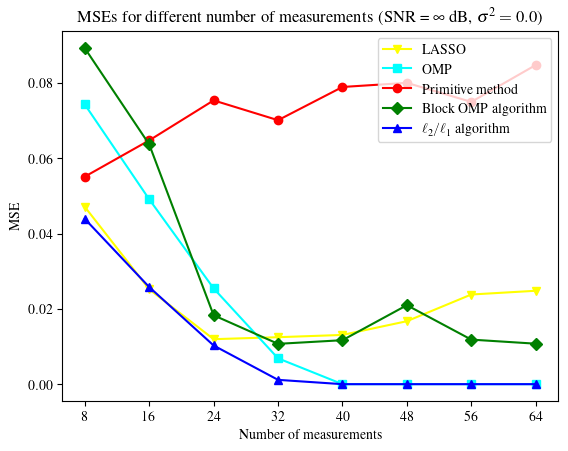

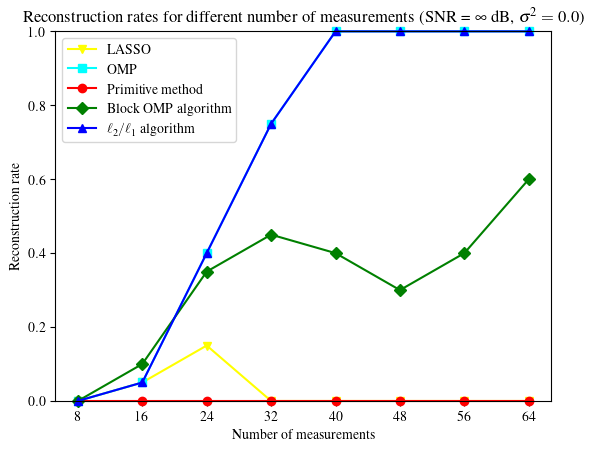

--------------------------------------------------
noise_var = 0.0005
M = 8


c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Average MSE LASSO = 0.0410
Average MSE OMP = 0.0575
Average MSE primitive method = 0.0542
Average MSE B-OMP = 0.1692
Average MSE l2/l1 = 0.0379
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 0.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.0000
Reconstruction rate l2/l1 = 0.0000
Signal reconstruction execution time with LASSO: 0.015 seconds
Signal reconstruction execution time with OMP: 0.018 seconds
Structured signal reconstruction execution time with primitive method: 16.127 seconds
Structured signal reconstruction execution time with B-OMP: 0.013 seconds
Structured signal reconstruction execution time with l2/l1: 3.047 seconds
M = 16
Average MSE LASSO = 0.0202
Average MSE OMP = 0.0468
Average MSE primitive method = 0.0630
Average MSE B-OMP = 0.0763
Average MSE l2/l1 = 0.0217
Reconstruction rate LASSO = 0.0500
Reconstruction rate OMP = 0.0500
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.0000
Reconstruction

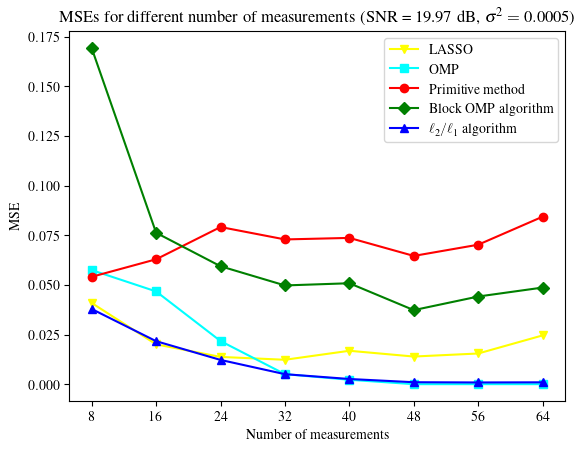

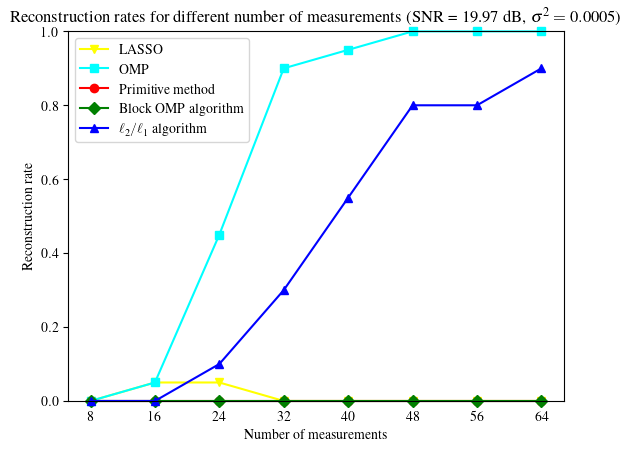

--------------------------------------------------
noise_var = 0.005
M = 8


c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Average MSE LASSO = 0.0505
Average MSE OMP = 0.0738
Average MSE primitive method = 0.0649
Average MSE B-OMP = 0.3907
Average MSE l2/l1 = 0.0469
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 0.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.0000
Reconstruction rate l2/l1 = 0.0000
Signal reconstruction execution time with LASSO: 0.018 seconds
Signal reconstruction execution time with OMP: 0.031 seconds
Structured signal reconstruction execution time with primitive method: 16.469 seconds
Structured signal reconstruction execution time with B-OMP: 0.015 seconds
Structured signal reconstruction execution time with l2/l1: 3.022 seconds
M = 16
Average MSE LASSO = 0.0318
Average MSE OMP = 0.0596
Average MSE primitive method = 0.0663
Average MSE B-OMP = 0.0859
Average MSE l2/l1 = 0.0300
Reconstruction rate LASSO = 0.0000
Reconstruction rate OMP = 0.0000
Reconstruction rate primitive method = 0.0000
Reconstruction rate B-OMP = 0.0000
Reconstruction

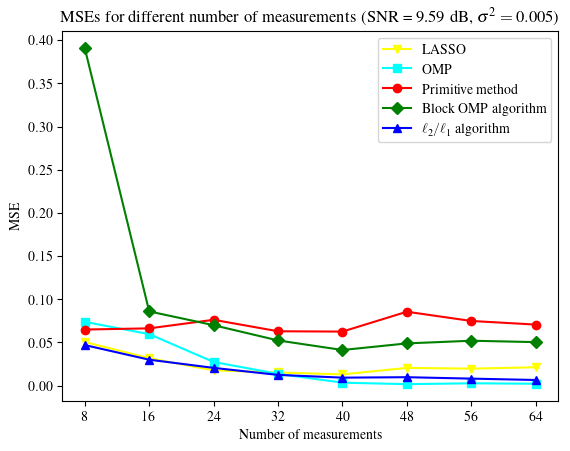

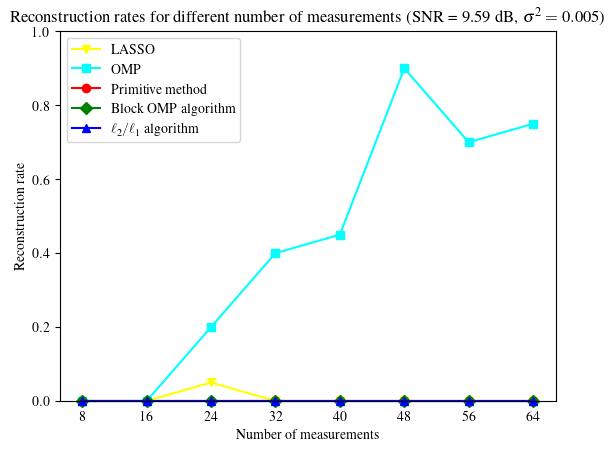

Average execution time for primitive method: 13.482 seconds
Average execution time for B-OMP: 0.020 seconds
Average execution time for l2/l1: 2.770 seconds
Total execution time for primitive method: 323.563 seconds
Total execution time for B-OMP: 0.492 seconds
Total execution time for l2/l1: 66.487 seconds


In [21]:
def sweep_sigma(silent=False):
    # noise_var_array = np.linspace(0.0, 0.1, 11)
    noise_var_array = np.array([0.0, 0.0005, 0.005])
    M_array = np.arange(8, N+1, 8)
    
    execution_times_lasso = np.zeros_like(noise_var_array, dtype=float)
    execution_times_omp = np.zeros_like(noise_var_array, dtype=float)
    execution_times_primitive = np.zeros_like(noise_var_array, dtype=float)
    execution_times_bomp = np.zeros_like(noise_var_array, dtype=float)
    execution_times_l2l1 = np.zeros_like(noise_var_array, dtype=float)

    for i, noise_variance in enumerate(noise_var_array):
        print("--------------------------------------------------")
        print(f"noise_var = {noise_variance}")

        
        mse_lasso, mse_omp, mse_structured_primitive_means, mse_structured_bomp_means, mse_structured_l2l1_means, \
        reconstruction_rates_lasso, reconstruction_rates_omp,reconstruction_rates_primitive, reconstruction_rates_bomp, reconstruction_rates_l2l1, \
        execution_time_lasso, execution_time_omp,execution_time_primitive, execution_time_bomp, execution_time_l2l1, snr_db = sweep_M(M_array, noise_variance=noise_variance, silent=silent)

        execution_times_lasso[i] = execution_time_lasso
        execution_times_omp[i] = execution_time_omp
        execution_times_primitive[i] = execution_time_primitive
        execution_times_bomp[i] = execution_time_bomp
        execution_times_l2l1[i] = execution_time_l2l1

        plot_mses(M_array, mse_lasso, mse_omp, mse_structured_primitive_means, mse_structured_bomp_means, mse_structured_l2l1_means, noise_variance, snr_db)
        plot_reconstruction_rates(M_array, reconstruction_rates_lasso, reconstruction_rates_omp, reconstruction_rates_primitive, reconstruction_rates_bomp, reconstruction_rates_l2l1, noise_variance, snr_db)

    average_execution_time_primitive = np.mean(execution_times_primitive)
    average_execution_time_bomp = np.mean(execution_times_bomp)
    average_execution_time_l2l1 = np.mean(execution_times_l2l1)

    total_execution_time_primitive = np.sum(execution_times_primitive) * M_array.size
    total_execution_time_bomp = np.sum(execution_times_bomp) * M_array.size
    total_execution_time_l2l1 = np.sum(execution_times_l2l1) * M_array.size

    print(f"Average execution time for primitive method: {average_execution_time_primitive:.3f} seconds")
    print(f"Average execution time for B-OMP: {average_execution_time_bomp:.3f} seconds")
    print(f"Average execution time for l2/l1: {average_execution_time_l2l1:.3f} seconds")

    print(f"Total execution time for primitive method: {total_execution_time_primitive:.3f} seconds")
    print(f"Total execution time for B-OMP: {total_execution_time_bomp:.3f} seconds")
    print(f"Total execution time for l2/l1: {total_execution_time_l2l1:.3f} seconds")

sweep_sigma(silent=False)